# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [4]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [6]:
import torch
import numpy as np
from dataset import TextDataset

In [4]:
train_set = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe')

In [5]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759

for _ in range(5):
    for dataset in (train_set, valid_set):
        indices, length = dataset[np.random.randint(len(dataset))]
        assert indices.shape == (dataset.max_length, )
        assert indices[0].item() == dataset.bos_id
        assert (indices == dataset.eos_id).sum().item() == 1

        eos_pos = indices.tolist().index(dataset.eos_id)
        assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
        assert (indices != dataset.pad_id).sum() == length

## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [7]:
from model import LanguageModel

In [7]:
model = LanguageModel(train_set)

In [8]:
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [8]:
from train import train
from pathlib import Path
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

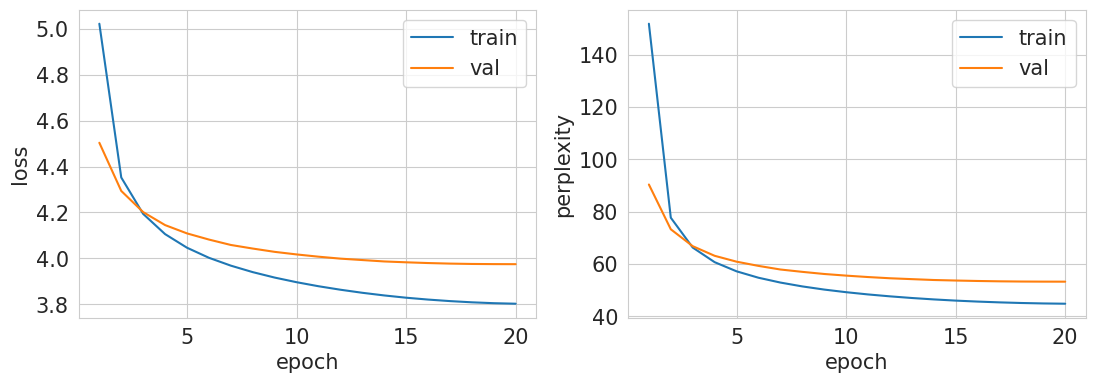

Generation examples:
если человек женился от поднятый в жизни человека в казинож.
лететь над ученым, самое главное и выбирать вполне остаться внут.
- какой же такое бабе, я устаю погумено! в яхле янвалый предлагаю большинством - бифханьер, не запрыгать со скоростью на щел!
- чем девушка в микровол для животных, одни периоды?- пока не на голову и застегнула прямого, колбасе, фрау, она есть.гола от одывась на одехо ленин.
- опера опять спалкой ваксо разлег данил!- какой сторожкого сольвиком?- потому что сотрудник, когда в которым он спросил вы думаете в я голова болва с курячка. и мысль нужно заходиться без следить за держит. помогающую превращается на уроках завязал, что приносить мумур съел.


In [ ]:
train(
    model, optimizer,
    scheduler, train_loader,
    valid_loader, num_epochs,
    num_examples=5, save_dir=Path('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints'),
    prev_best_val_loss=None, train_name='RNN'
)

## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set, rnn_type=nn.LSTM)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

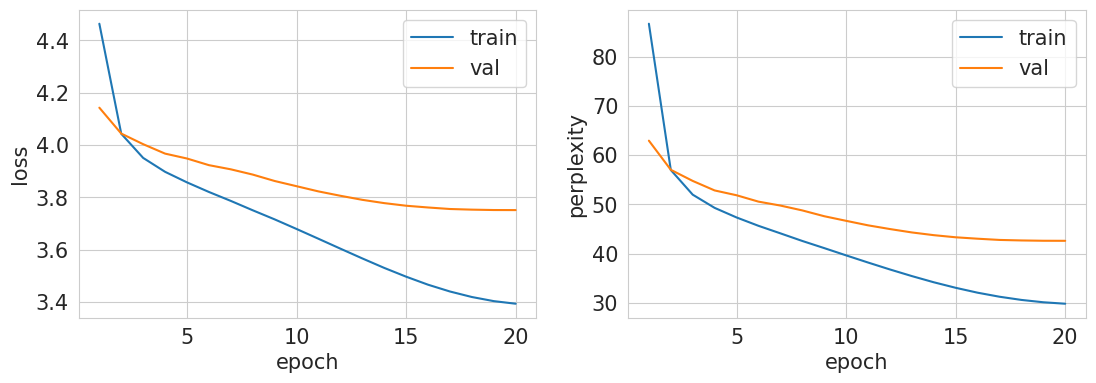

Generation examples:
- у вас в социальных кладбище всегда сохранители таскаться.- и что ты это делаешь? армении?- машины мыши!
- кто на улице вежливый?- так повезло, все доверчиво отвечает- это сам, недостаточно. а у нас знакомый, гад в том, что никакого здоровья, а может у вас была недалеко, вижу, что лучше говорить, этот моновый хй тоже?!
многие люди ежа не на зиму.
по кличке в его жизни спалик, ничем так сильно скрываешь у себя делаю планы с луком. последний вопрос шведникам.
- владимир владимирович за что?ему уму не берете и верлиливаться в моментах. мне укольне две вещи.- давай ему скажешь из-за ваших грех...


In [ ]:
train(
    model, optimizer,
    scheduler, train_loader,
    valid_loader, num_epochs,
    num_examples=5, save_dir=Path('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints'),
    prev_best_val_loss=None, train_name='LSTM'
)

In [ ]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

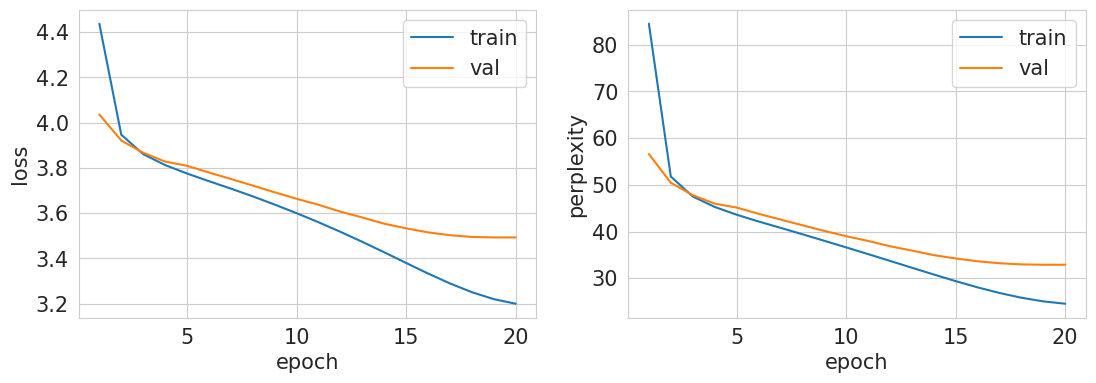

Generation examples:
учитель происходит антисоубийце-моглапов и понял ю-а-а- внук, двадцати два человек три сапогом, комментарий!
офигенно на народ кастрирована на отдых передачи советского рельса.- где ваши руки?ничок-долго-да, что, опять, выделен нашей на выставке директоров?все мнения и радостно медленно переводил из пруда климата- еще какая медицина гадина, правда!
у меня вообще делают только строе и то, что она выстреляет плавать.
из волны жена очень любила готовить его до первого.
умер народ всегда ходит по футболу. оно и не может снег.


In [ ]:
train(
    model, optimizer,
    scheduler, train_loader,
    valid_loader, num_epochs,
    num_examples=5, save_dir=Path('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints'),
    prev_best_val_loss=None, train_name='LSTM_2_layers'
)

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [20]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set, rnn_type=nn.LSTM, rnn_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

In [21]:
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_2_layers_best_checkpoint.pth')
model.load_state_dict(best_checkpoint['model_state'])
model.eval()

LanguageModel(
  (embedding): Embedding(2000, 256, padding_idx=0)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=2000, bias=True)
)

In [28]:
temp_arr = np.logspace(-3, 3, 7)

for prefix in ['', 'идет штирлиц по берлину', 'летят в самолете русский, немец и американец']:
    print(f'prefix: {prefix}')
    for temp in temp_arr:
        print(f'temperature = {temp:.0e}')
        for _ in range(3):
            print(model.inference(prefix, temp))

prefix: 
temperature = 1e-03
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом снимаешь нахрена...
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом снимаешь нахрена...
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом снимаешь нахрена...
temperature = 1e-02
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом снимаешь нахрена...
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом снимаешь нахрена...
- а ты знаешь, что такое участники?- это когда ты находишь в кармане, а потом снимаешь нахрена, а потом еще и включишь.
temperature = 1e-01
- а ты знаешь, что у меня в голове?- да, но я не могу понять, что ты не знаешь, что ты мне не нужен.
- а ты знаешь, что такое участники?- это когда ты находишь в кармане задницу, а то у тебя 

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [13]:
train_set_bpe_big_vocab = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=True, sp_model_prefix='bpe_big_vocab', vocab_size=8000)
valid_set_bpe_big_vocab = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe_big_vocab', vocab_size=8000)

In [14]:
train_loader = DataLoader(train_set_bpe_big_vocab, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set_bpe_big_vocab, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set_bpe_big_vocab, rnn_type=nn.LSTM, rnn_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

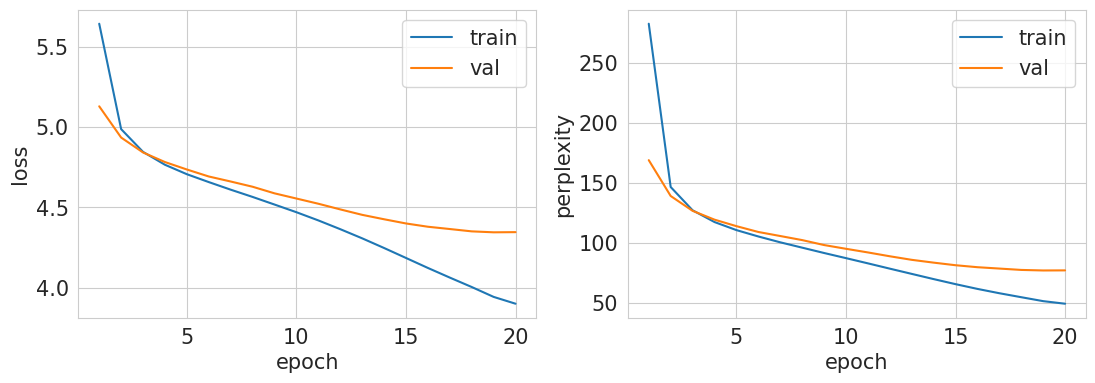

Generation examples:
вчера в связи с бельной жизни вышел из свидете.но аспиранчук и убивал домашняя дурем.
еврейская школа по инци выйдиванию из-за новостей.
новый грустный циклопрят будет фигня.правольцы уазы говорят они прячут свои виагры, чтобы проверить детей сам.
летом на скинхельном плане новый вакциция не пугает литров тителейной карточкой. непонятно, зачем много того.
если вы думаете, что вами не любишь отказывайте, то вы кажется, что других политиков, тяжеловных россиян имуществ не во время счетчица, всего добра не будут.


In [15]:
train(
    model, optimizer,
    scheduler, train_loader,
    valid_loader, num_epochs,
    num_examples=5, save_dir=Path('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints'),
    prev_best_val_loss=None, train_name='LSTM_bpe_big_vocab'
)

In [17]:
train_set_unigram = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=True, sp_model_prefix='unigram', vocab_size=6000, model_type='unigram')
valid_set_unigram = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=6000, model_type='unigram')

In [26]:
train_loader = DataLoader(train_set_unigram, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
valid_loader = DataLoader(valid_set_unigram, batch_size=128, shuffle=False)

num_epochs = 20
model = LanguageModel(train_set_unigram, rnn_type=nn.LSTM, rnn_layers=2)
model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-5)

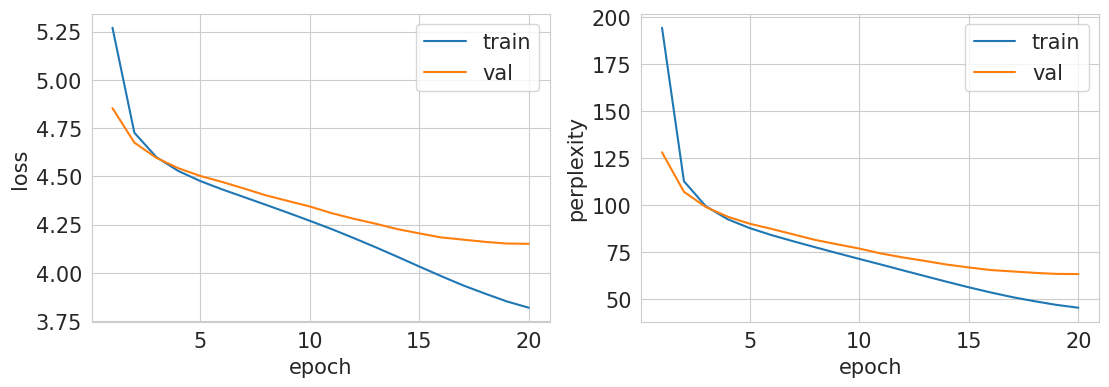

Generation examples:
- у меня мальчиком застойная пахнет!- а?- да вот, пусти!
- доченька, знаешь мое окно помидор.- неужели у дяды был женский?- нет... дипертная!
пришла бы привет дочери борисана из пяти бабушек. на день рождения она к мамау, втащил брузев, расконец капиля и входит видеть, пока не бредется, посмотрел нарозски и и к призыву не доверяй...
если бы наши блохи смогут закрыть  ⁇ 00 ратен по учебе, свежей не пойду бы на дачу, и дальше наши строгие качные будут вообще мусора раздвигать.
с моим ребенком красят дорога. подхожу к выводу, что девачны уже 15.


In [27]:
train(
    model, optimizer,
    scheduler, train_loader,
    valid_loader, num_epochs,
    num_examples=5, save_dir=Path('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints'),
    prev_best_val_loss=None, train_name='LSTM_unigram'
)

__Вывод:__ увеличение словаря не привело к увеличению качества, потому что у модели стало больше вариантов для выбора следующего токена. Именно поэтому сравнение по perplexity моделей с разным токенизаторами не является абсолютно корректным

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

def lsa(model, val_dataset):
    model.eval()
    true_texts = []
    generated_texts = []
    vectorizer = TfidfVectorizer()
    n = len(val_dataset)

    for tokens, _ in tqdm(val_dataset):
        true_texts.append(val_dataset.ids2text(tokens))
        generated_texts.append(model.inference())

    true_texts.extend(generated_texts)
    X = vectorizer.fit_transform(true_texts)
    svd = TruncatedSVD(n_components=128, random_state=42)
    reduced_X = svd.fit_transform(X)

    true_vectors = reduced_X[:n] # (n, n_components)
    generated_vectors = reduced_X[n:]

    sim_matrix = cosine_similarity(generated_vectors, true_vectors)
    lsa = np.mean(np.max(sim_matrix, axis=1))

    return lsa, true_vectors, generated_vectors

In [11]:
valid_set = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe')
model_bpe = LanguageModel(valid_set, rnn_type=nn.LSTM, rnn_layers=2)
model_bpe.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_2_layers_best_checkpoint.pth')
model_bpe.load_state_dict(best_checkpoint['model_state'])
model_bpe.eval()

lsa_bpe, true_vec_bpe, gen_vec_bpe = lsa(model_bpe, valid_set)

100%|██████████| 6038/6038 [02:28<00:00, 40.65it/s]


In [12]:
valid_set_bpe_big_vocab = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe_big_vocab', vocab_size=8000)
model_bpe_big_vocab = LanguageModel(valid_set_bpe_big_vocab, rnn_type=nn.LSTM, rnn_layers=2)
model_bpe_big_vocab.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_bpe_big_vocab_best_checkpoint.pth')
model_bpe_big_vocab.load_state_dict(best_checkpoint['model_state'])
model_bpe_big_vocab.eval()

lsa_bpe_big_vocab, true_vec_bpe_big_vocab, gen_vec_bpe_big_vocab = lsa(model_bpe_big_vocab, valid_set_bpe_big_vocab)

100%|██████████| 6038/6038 [01:54<00:00, 52.55it/s]


In [13]:
valid_set_unigram = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=6000, model_type='unigram')
model_unigram = LanguageModel(valid_set_unigram, rnn_type=nn.LSTM, rnn_layers=2)
model_unigram.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_unigram_best_checkpoint.pth')
model_unigram.load_state_dict(best_checkpoint['model_state'])
model_unigram.eval()

lsa_unigram, true_vec_unigram, gen_vec_unigram = lsa(model_unigram, valid_set_unigram)

100%|██████████| 6038/6038 [01:57<00:00, 51.25it/s]


In [39]:
print(f'LSTM bpe lsa: {float(lsa_bpe):.3f}')
print(f'LSTM bpe big vocab lsa: {float(lsa_bpe_big_vocab):.3f}')
print(f'LSTM unigram lsa: {float(lsa_unigram):.3f}')

LSTM bpe lsa: 0.697
LSTM bpe big vocab lsa: 0.699
LSTM unigram lsa: 0.704


## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_points(true_vec, gen_vec, ax, name):
    tsne = TSNE(n_components=2)
    n = true_vec.shape[0]
    points = tsne.fit_transform(np.r_[true_vec, gen_vec])
    true_points = points[:n]
    gen_points = points[n:]
    ax.scatter(true_points[:, 0], true_points[:, 1], label='True')
    ax.scatter(gen_points[:, 0], gen_points[:, 1], label='Generated')
    ax.legend()
    ax.set_title(name)

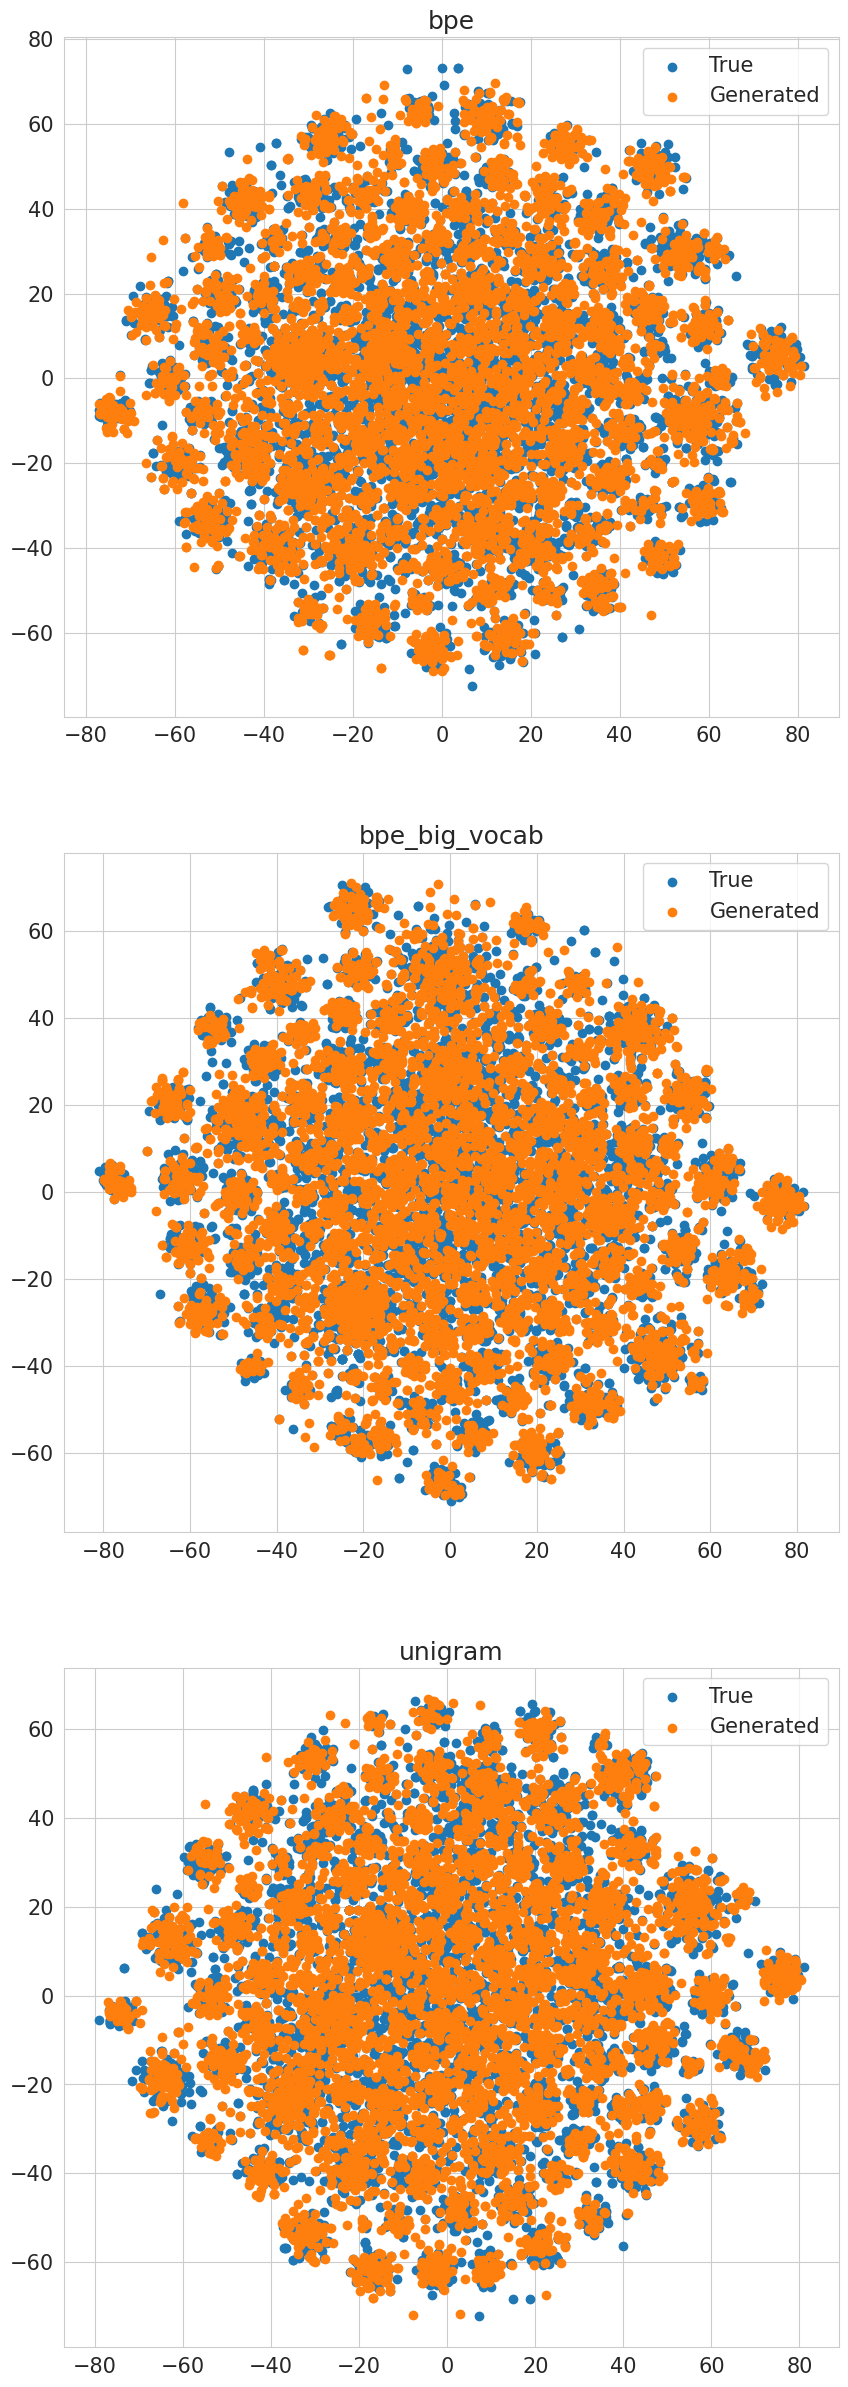

<Figure size 640x480 with 0 Axes>

In [18]:
_, axs = plt.subplots(nrows=3, figsize=(10, 30))

plot_points(true_vec_bpe, gen_vec_bpe, axs[0], 'bpe')
plot_points(true_vec_bpe_big_vocab, gen_vec_bpe_big_vocab, axs[1], 'bpe_big_vocab')
plot_points(true_vec_unigram, gen_vec_unigram, axs[2], 'unigram')
plt.show()
plt.tight_layout()

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [9]:
from transformers import AutoTokenizer, AutoModelForCausalLM

RUGPT_TOKENIZER = AutoTokenizer.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2")
RUGPT_MODEL = AutoModelForCausalLM.from_pretrained("sberbank-ai/rugpt3small_based_on_gpt2").to(device)

In [16]:
def calc_perplexity(model, size=3000, calc_model=RUGPT_MODEL, tokenizer=RUGPT_TOKENIZER):
    model.eval()
    generated_texts = [model.inference() for _ in tqdm(range(size))]
    encodings = tokenizer("\n".join(generated_texts), return_tensors="pt")

    max_length = calc_model.config.n_positions
    stride = 500
    seq_len = encodings.input_ids.size(1)
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop
        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100

        with torch.no_grad():
            outputs = calc_model(input_ids, labels=target_ids)

            # loss is calculated using CrossEntropyLoss which averages over valid labels
            # N.B. the model only calculates loss over trg_len - 1 labels, because it internally shifts the labels
            # to the left by 1.
            neg_log_likelihood = outputs.loss

        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        if end_loc == seq_len:
            break

    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    return torch.exp(avg_nll).item()

In [12]:
valid_set = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe')
model_bpe = LanguageModel(valid_set, rnn_type=nn.LSTM, rnn_layers=2)
model_bpe.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_2_layers_best_checkpoint.pth')
model_bpe.load_state_dict(best_checkpoint['model_state'])
model_bpe.eval()

valid_set_bpe_big_vocab = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='bpe_big_vocab', vocab_size=8000)
model_bpe_big_vocab = LanguageModel(valid_set_bpe_big_vocab, rnn_type=nn.LSTM, rnn_layers=2)
model_bpe_big_vocab.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_bpe_big_vocab_best_checkpoint.pth')
model_bpe_big_vocab.load_state_dict(best_checkpoint['model_state'])
model_bpe_big_vocab.eval()

valid_set_unigram = TextDataset(data_file='/content/drive/MyDrive/DL/DL_HSE/homework 3/jokes.txt', train=False, sp_model_prefix='unigram', vocab_size=6000, model_type='unigram')
model_unigram = LanguageModel(valid_set_unigram, rnn_type=nn.LSTM, rnn_layers=2)
model_unigram.to(device)
best_checkpoint = torch.load('/content/drive/MyDrive/DL/DL_HSE/homework 3/models_checkpoints/LSTM_unigram_best_checkpoint.pth')
model_unigram.load_state_dict(best_checkpoint['model_state'])
model_unigram.eval()

LanguageModel(
  (embedding): Embedding(6000, 256, padding_idx=0)
  (rnn): LSTM(256, 256, num_layers=2, batch_first=True)
  (linear): Linear(in_features=256, out_features=6000, bias=True)
)

In [17]:
print(f'LLM perplexity bpe: {calc_perplexity(model_bpe):.3f}')
print(f'LLM perplexity bpe big vocab: {calc_perplexity(model_bpe_big_vocab):.3f}')
print(f'LLM perplexity unigram: {calc_perplexity(model_unigram):.3f}')

 98%|█████████▊| 169/173 [00:31<00:00,  5.37it/s]


LLM perplexity bpe: 477.271


 98%|█████████▊| 169/173 [00:32<00:00,  5.18it/s]


LLM perplexity bpe big vocab: 504.722


 98%|█████████▊| 167/171 [00:32<00:00,  5.17it/s]

LLM perplexity unigram: 486.273


## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.

In [75]:
model_bpe.inference('шел медведь по лесу', temp=0.5)

'шел медведь по лесу, а навстречу ему окурок. вот как, подумал штирлиц и повесил табличку в обморок.'

In [80]:
model_bpe.inference('шел медведь по лесу', temp=0.5)

'шел медведь по лесу, а там никого нет...'